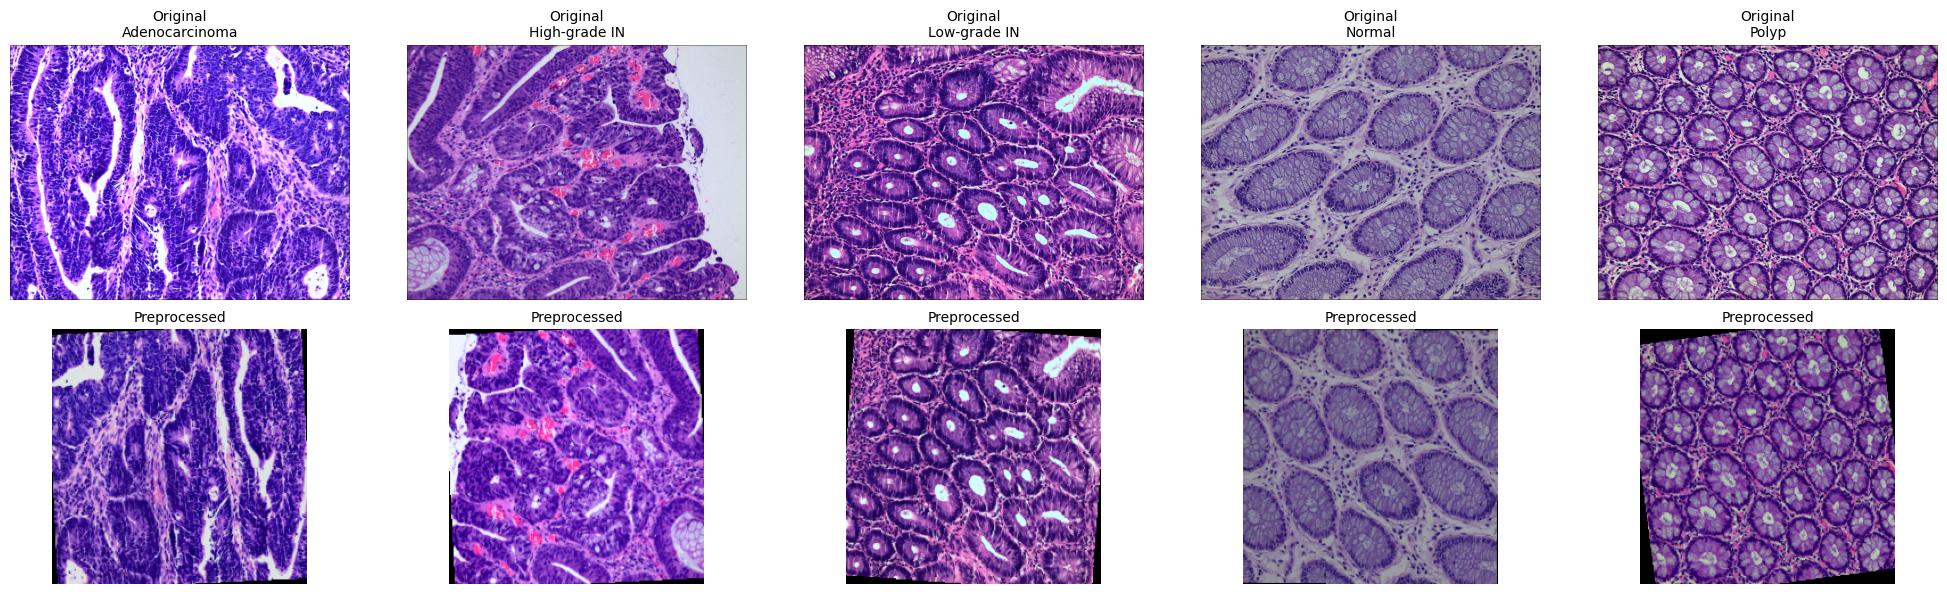

Found 1472 images belonging to 5 classes.
Found 367 images belonging to 5 classes.


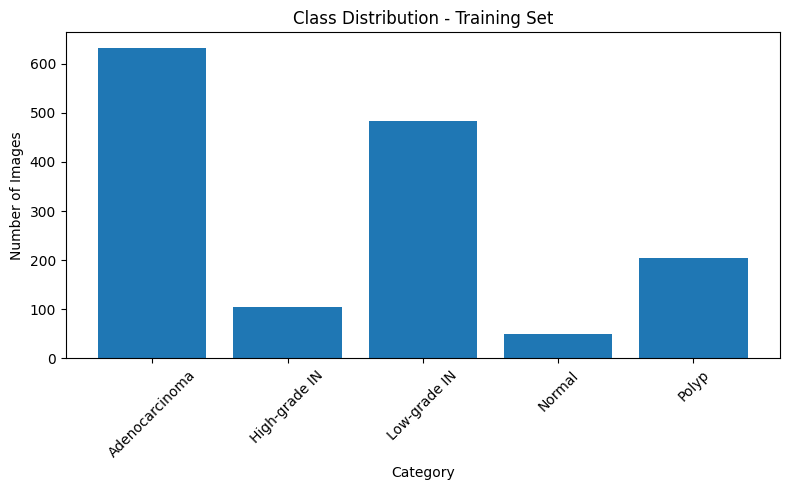

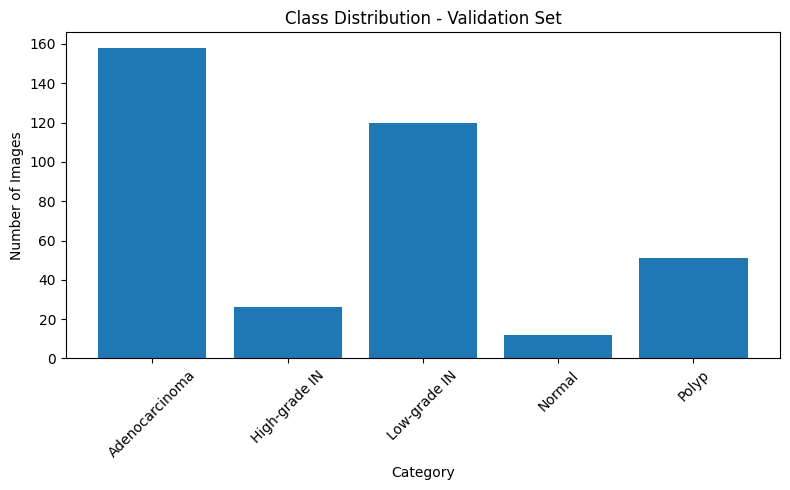

In [16]:

import os
import matplotlib.pyplot as plt
import random
from PIL import Image
from torchvision import transforms
import torchvision.transforms.functional as F
import torch
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set path and parameters
data_dir = '/content/drive/MyDrive/project/200'
img_size = 224
img_height, img_width = 224, 224
batch_size = 32

# Data augmentation and normalization (for PyTorch visualization)
transform_pipeline = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

# Denormalize tensor and convert to PIL image (for visualization)
def denorm_to_pil(tensor_img, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    img = tensor_img * std + mean
    img = torch.clamp(img, 0, 1)
    return F.to_pil_image(img)

# Select one sample image from each category
def get_sample_images(data_dir, max_categories=5):
    image_paths = []
    categories = sorted([folder for folder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, folder))])
    for category in categories:
        category_path = os.path.join(data_dir, category)
        images = [img for img in os.listdir(category_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if images:
            img_name = random.choice(images)
            image_paths.append((os.path.join(category_path, img_name), category))
        if len(image_paths) >= max_categories:
            break
    return image_paths

# Show original vs preprocessed images (2 rows × 5 columns)
def show_comparison(image_paths):
    plt.figure(figsize=(20, 6))
    for i, (img_path, label) in enumerate(image_paths):
        original = Image.open(img_path).convert('RGB')
        transformed = transform_pipeline(original)
        final_img = denorm_to_pil(transformed)

        # top_original
        plt.subplot(2, 5, i + 1)
        plt.imshow(original)
        plt.title(f"Original\n{label}", fontsize=10)
        plt.axis('off')

        # bottom
        plt.subplot(2, 5, 5 + i + 1)
        plt.imshow(final_img)
        plt.title("Preprocessed", fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

#  Execute visualization
sample_images = get_sample_images(data_dir, max_categories=5)
show_comparison(sample_images)

# Use ImageDataGenerator to split dataset (not for training)
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.1
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# show charts
def plot_class_distribution(generator, title):
    import numpy as np
    labels = generator.classes
    class_indices = generator.class_indices
    class_names = list(class_indices.keys())
    counts = [np.sum(labels == i) for i in range(len(class_names))]

    plt.figure(figsize=(8, 5))
    plt.bar(class_names, counts)
    plt.title(title)
    plt.xlabel("Category")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_class_distribution(train_generator, "Class Distribution - Training Set")
plot_class_distribution(val_generator, "Class Distribution - Validation Set")
